In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import transformers
from utils.common_functions import loss_fn
from sklearn.metrics import roc_curve,confusion_matrix,auc
from utils.common_functions import log_metrics
from utils.dataset import MyDataset

import warnings
warnings.filterwarnings('ignore')
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

2023-06-29 17:41:08.178672: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-29 17:41:08.221893: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-29 17:41:08.849808: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
df1 = pd.read_csv("/home/siu856533724/code/source-code/Social-Networks/Trend-Prediction/DataSet/csv/goemotions_1.csv", encoding='utf8')
df2 = pd.read_csv("/home/siu856533724/code/source-code/Social-Networks/Trend-Prediction/DataSet/csv/goemotions_2.csv", encoding='utf8')
df3 = pd.read_csv("/home/siu856533724/code/source-code/Social-Networks/Trend-Prediction/DataSet/csv/goemotions_3.csv", encoding='utf8')
df4 = pd.read_csv("/home/siu856533724/code/source-code/Social-Networks/Trend-Prediction/DataSet/csv/reddit_emotions_processed.csv", encoding='utf8')

In [3]:
df = pd.concat([df1, df2, df3, df4], axis=0)

In [4]:
from utils.preprocessing import get_clean_dataset
df = get_clean_dataset(df)

In [5]:
fractions = np.array([0.7, 0.2, 0.1])
# shuffle your input
df = df.sample(frac=1) 
# split into 3 parts
train, valid, test = np.array_split(
    df, (fractions[:-1].cumsum() * len(df)).astype(int))

In [6]:
from utils.common_functions import get_emotions
emotions = get_emotions().values()
n_labels = len(emotions)
def get_labels():
    labels = list(emotions)
    return labels

In [7]:
# model_ckpt = "distilbert-base-uncased"
model_ckpt="bert-base-uncased"
# model_ckpt="bert-large-uncased"
# model_ckpt = "squeezebert/squeezebert-uncased"

In [8]:
from transformers import AutoTokenizer, AutoModel, BertModel
from utils.model import TextClassification, TextClassificationBertLSTM
model = TextClassification(n_classes=28, dropout=0.9, model_ckpt=model_ckpt)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [9]:
model_dir = "/home/siu856533724/code/source-code/Social-Networks/Trend-Prediction/Main-Implementation/model_save/best_model_27_06_2023-13_03_43.pt"#output_dir+MODEL_FILE_NAME
output_dir = '/home/siu856533724/code/source-code/Social-Networks/Trend-Prediction/Main-Implementation/model_save'
model = torch.load(model_dir)
model_to_save = model.module if hasattr(model, 'module') else model
model = model_to_save

In [10]:
tokenizer = transformers.AutoTokenizer.from_pretrained(output_dir, do_lower_case=True)

In [11]:
test_dataset = MyDataset(test.text.tolist(), test[get_labels()].values.tolist(), tokenizer, 90)
test_data_loader = DataLoader(test_dataset, batch_size=8, shuffle=True, num_workers=1)

In [12]:
fin_targets = []
fin_outputs = []
with torch.no_grad():
       for i, batch in tqdm(enumerate(test_data_loader), total=len(test_data_loader)):
              ids = batch["input_ids"]
              token_type_ids = batch['token_type_ids']
              mask = batch["attention_mask"]
              targets = batch["labels"]

              ids = ids.to(device, dtype=torch.long)
              mask = mask.to(device, dtype=torch.long)
              token_type_ids = token_type_ids.to(device, dtype=torch.long)
              targets = targets.to(device, dtype=torch.float)

              outputs = model(ids=ids, mask=mask, token_type_ids=token_type_ids)
              loss = loss_fn(outputs, targets)
              eval_loss = loss.item()
              fin_targets.extend(targets)
              fin_outputs.extend(torch.sigmoid(outputs))

  0%|          | 0/3691 [00:00<?, ?it/s]

In [13]:
import seaborn as sns
from sklearn.metrics import roc_curve,confusion_matrix,auc

In [19]:
def roc_curve_plot(fpr,tpr,roc_auc):
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' %roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('')
    plt.legend(loc="lower right")
    plt.show()

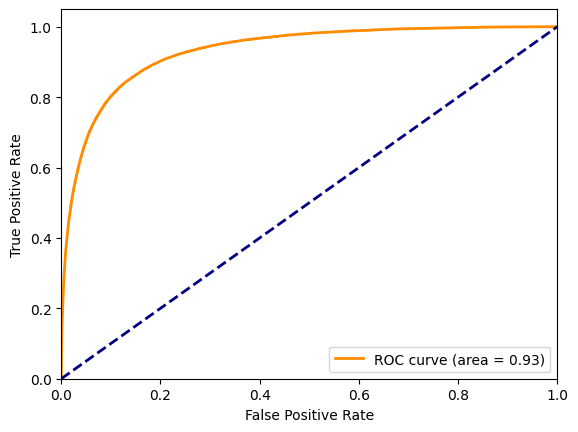

In [20]:
log = log_metrics(fin_outputs, fin_targets)

roc_curve_plot(log['fpr'], log['tpr'], log['auc_micro'])


In [16]:
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
from matplotlib import cm
top = cm.get_cmap('OrRd_r', 128) # r means reversed version
bottom = cm.get_cmap('OrRd', 128)# combine it all
newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0, 1, 128))))# create a new colormaps with a name of OrangeBlue
orange_blue = ListedColormap(newcolors, name='OrangeBlue')

In [17]:

def plot_cm(y_pred, y_true, title):
    y_pred = torch.stack(y_pred)
    y_pred = y_pred.cpu().data.numpy()
    y_true = torch.stack(y_true)
    y_true = y_true.cpu().data.numpy()

    y_pred = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_true, axis=1)
    
    figsize=(30,30)
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    # print(cm)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f' % p
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f' % p
    cm = pd.DataFrame(cm, index=get_labels(), columns=get_labels())
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    plt.title(title)
    #cmap = Blues, viridis, plasma, inferno, magma, cividis, PiYG, RdGy, RdBu, BrBG, coolwarm
    sns.heatmap(cm, cmap=orange_blue, annot=None, fmt='', ax=ax)

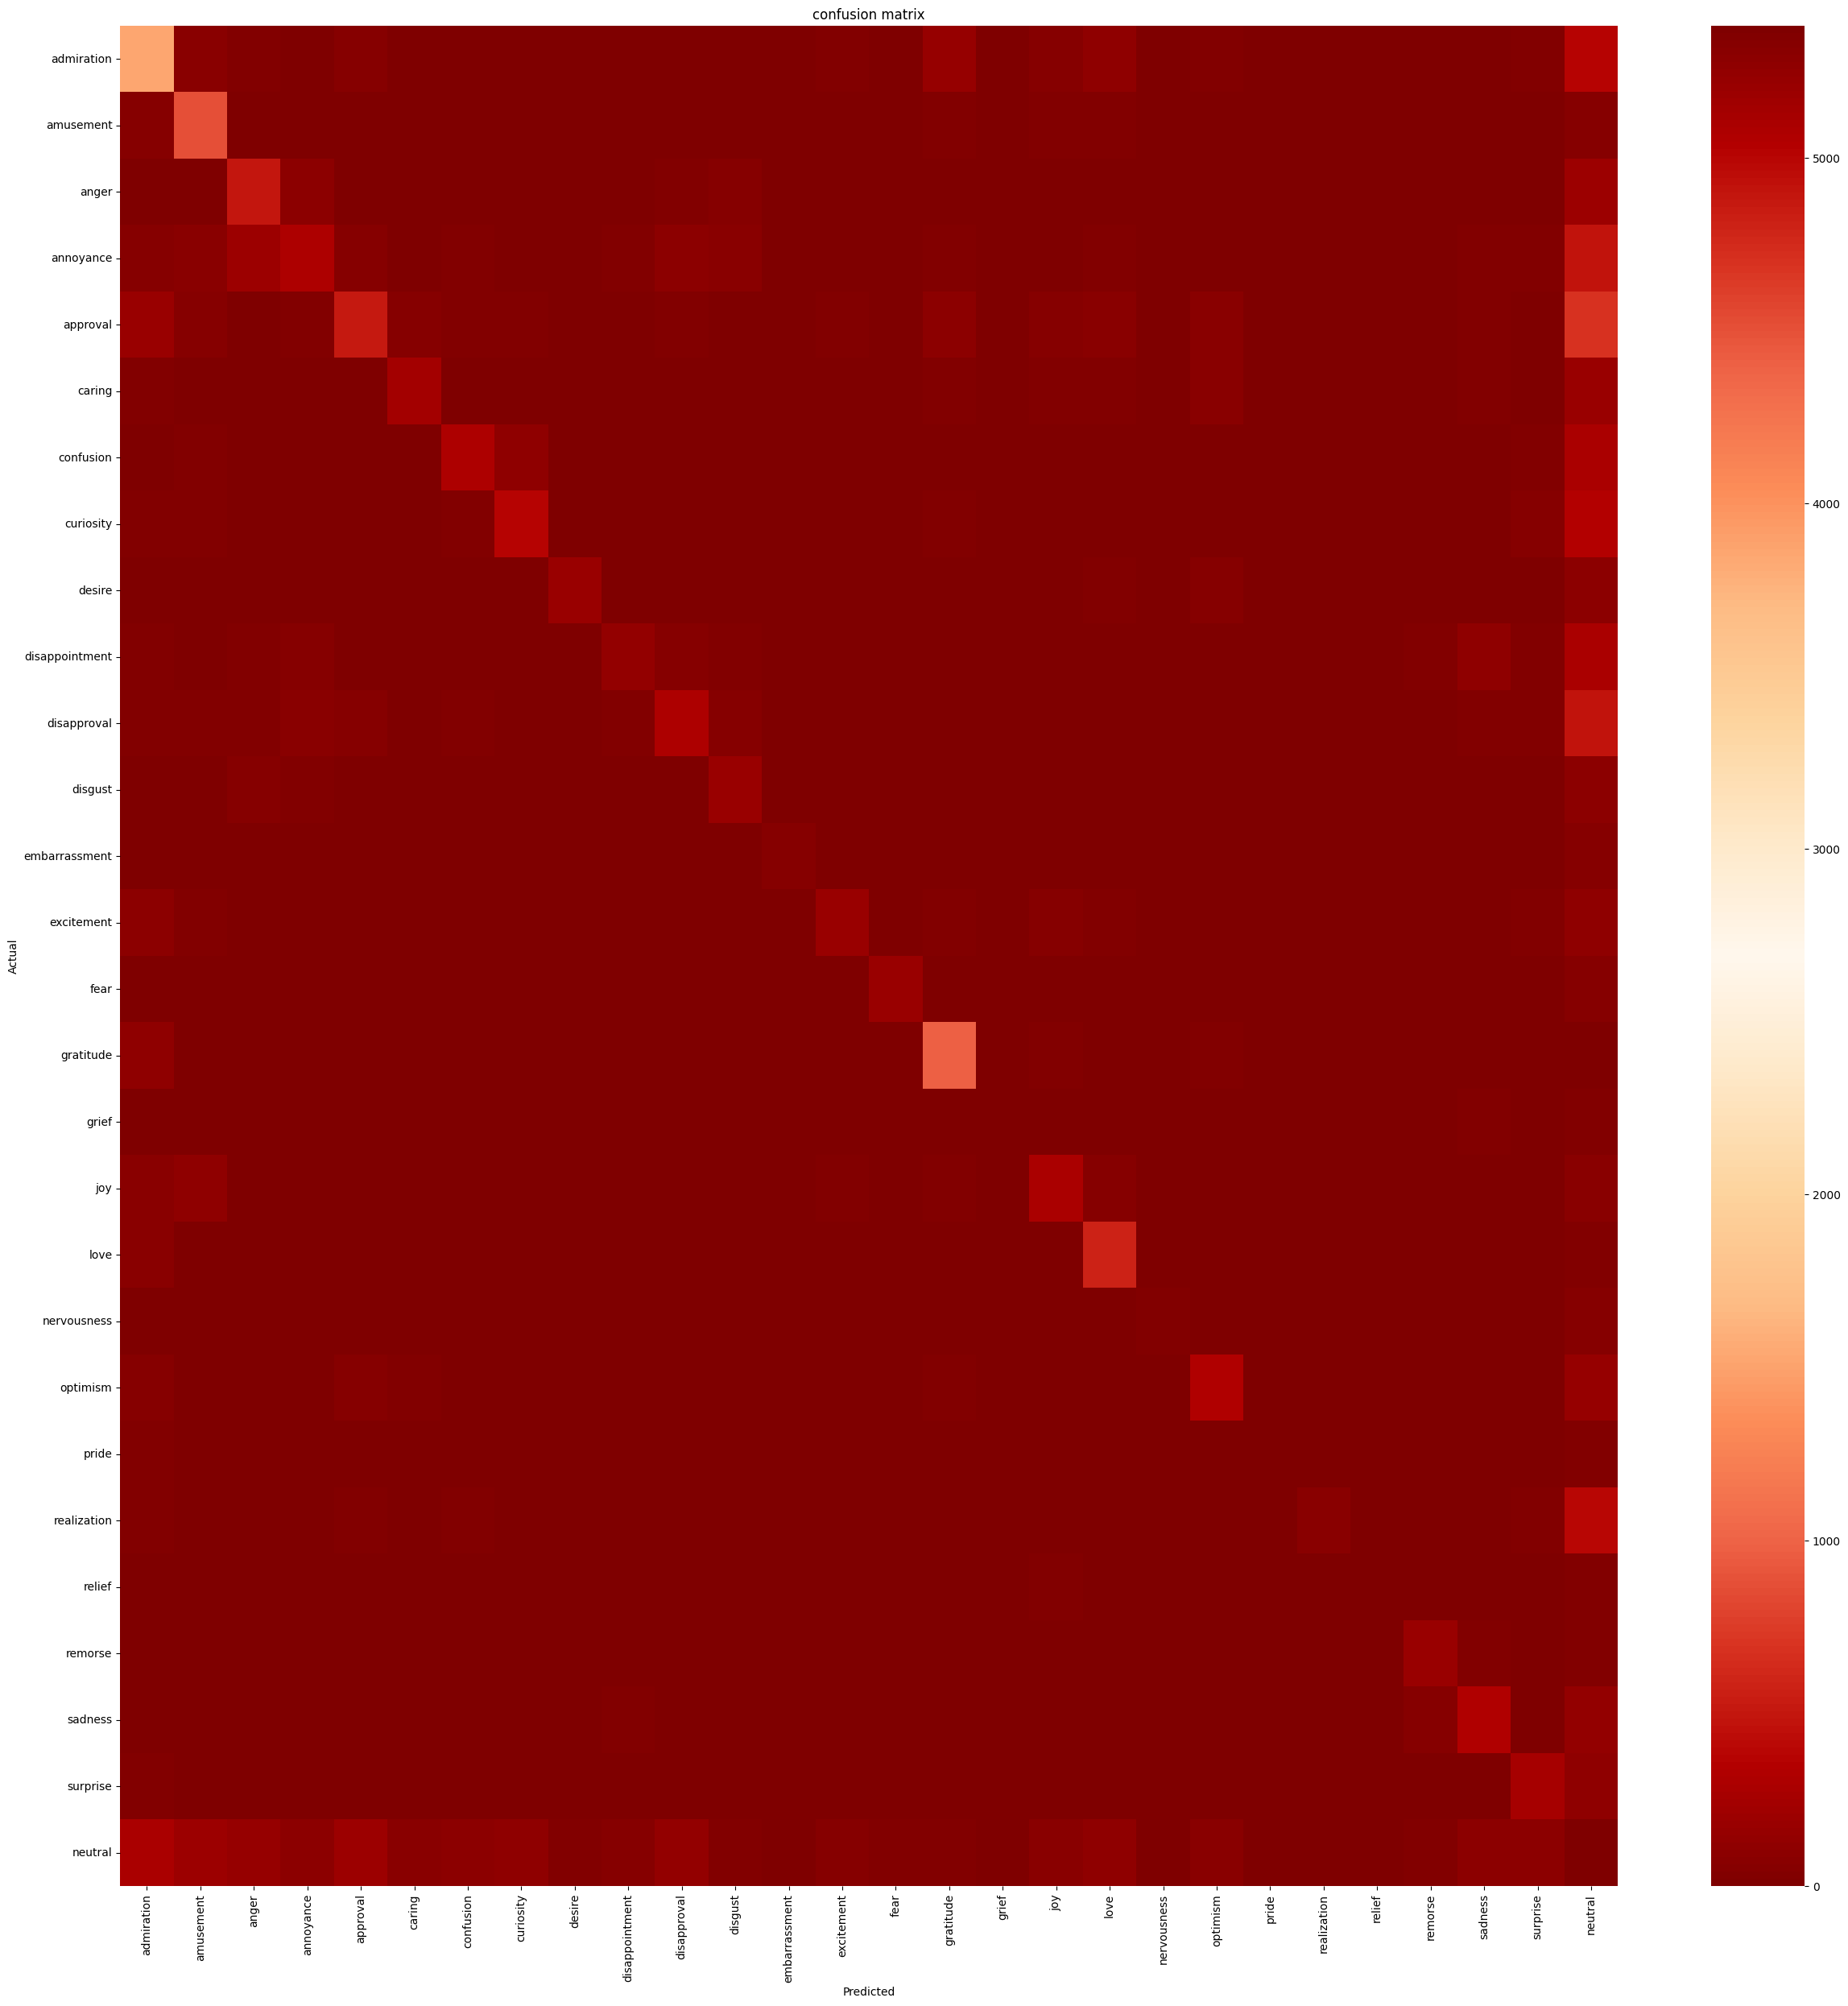

In [18]:
plot_cm(fin_outputs, fin_targets, "confusion matrix")